In [30]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'jshtml'
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random
import time
random.seed(12345)

In [31]:
class Food(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_marked = False
        self.random.seed(12345)


In [32]:
class Bin(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.random.seed(12345)

In [33]:
class Waiter(Agent):
    def __init__(self, unique_id, model, x_range):
        super().__init__(unique_id, model)
        self.random.seed(12345)
        self.x_range = x_range
        self.carrying_food = False
        self.in_column = True
        self.horizontal_direction = 1
        self.vertical_direction = 1
        self.current_x = x_range[0]
        self.food_picking_steps = []

    def move(self):
        if self.model.bin_position == None and self.carrying_food == False:
            self.search_bin()
        elif (
            self.carrying_food == True
            and self.model.bin_position != None
            and self.model.agent_in_bin == False
        ):
            self.move_to_target(self.model.bin_position)
        else:
            self.search_food()

    def search_routine(self):
        # Moverse en el eje X
        new_x = self.pos[0] + self.horizontal_direction

        # Verificar si ha llegado al final o al principio del rango de columna
        if new_x > self.x_range[1] or new_x < self.x_range[0]:
            self.horizontal_direction *= -1  # Cambiar dirección horizontal
            new_x = self.pos[0]  # Mantenerse en la misma columna
            new_y = (
                self.pos[1] + self.vertical_direction
            )  # Moverse en la dirección vertical

            # Verificar si ha llegado al final o principio del grid verticalmente
            if new_y >= self.model.grid.height or new_y < 0:
                self.vertical_direction *= -1  # Cambiar dirección vertical
                new_y = (
                    self.pos[1] + self.vertical_direction
                )  # Moverse en la nueva dirección vertical
        else:
            new_y = self.pos[1]

        # Moverse a la nueva posición
        new_position = (new_x, new_y)
        self.model.grid.move_agent(self, new_position)

    def search_bin(self):
        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(
                agent, Bin
            ):  # Suponiendo que Bin es una clase para los agentes contenedor
                self.model.bin_position = self.pos
                return
            elif isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)

        self.search_routine()

    def pick_food(self, agent):
        self.model.grid.remove_agent(agent)
        self.model.schedule.remove(agent)
        self.model.matrix[self.pos[0]][self.pos[1]] = 0
        self.food_picking_steps.append(self.model.schedule.steps)

    def search_food(self):
        # Regresa a su rango de columnas si se sale de él
        if self.pos[0] not in range(self.x_range[0], self.x_range[1] + 1):
            self.move_to_target((self.x_range[0], self.pos[1]))
            return

        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)
                self.carrying_food = True
                self.pick_food(agent)

        self.search_routine()

    def distance_to_target(self, pos, target_pos):
        distance_x, distance_y = pos[0] - target_pos[0], pos[1] - target_pos[1]
        return abs(distance_x) + abs(distance_y)

    def find_nearest_food(self):
        foods = [food for food in self.model.marked_food]
        if not foods:
            return None

        closest = min(foods, key=lambda food: self.distance_to_target(self.pos, food))
        return closest

    def move_to_target(self, target_pos):
        if self.pos == self.model.bin_position and self.carrying_food == True:
            self.place_food()
            self.model.agent_in_bin = False
            return

        if self.pos == target_pos and self.carrying_food == False:
            current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
            for agent in current_cell_contents:
                if isinstance(agent, Food):
                    self.carrying_food = True
                    self.pick_food(agent)
            return

        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)

        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )

        possible_steps = [
            step
            for step in possible_steps
            if not any(
                isinstance(agent, Waiter)
                for agent in self.model.grid.get_cell_list_contents(step)
            )
        ]

        best_step = min(
            possible_steps, key=lambda pos: self.distance_to_target(pos, target_pos)
        )

        self.model.grid.move_agent(self, best_step)

    def place_food(self):
        self.model.agent_in_bin = True
        self.model.grid.place_agent(self, self.model.bin_position)
        self.carrying_food = False
        self.model.food_placed += 1

    def step(self):
        self.move()


In [34]:
def get_grid_size(model):
    grid_data = [
        {
            "id": "grid",
            "width": model.grid.width,
            "height": model.grid.height,
        }
    ]
    return grid_data


def get_bin_position(model):
    bin_data = [
        {
            "id": agent.unique_id,
            "position": {"x": agent.pos[0], "y": agent.pos[1]},
        }
        for agent in model.schedule.agents
        if isinstance(agent, Bin)
    ]
    return bin_data


def get_waiter_position(model):
    waiters_data = [
        {
            "id": agent.unique_id,
            "position": {"x": agent.pos[0], "y": agent.pos[1]},
            # Conditional for carrying food "true" == 1, "false" == 0
            "carrying_food": 1 if agent.carrying_food else 0,
        }
        for agent in model.schedule.agents
        if isinstance(agent, Waiter)
    ]
    return waiters_data


def get_food_position(model):
    food_data = [
        {
            "id": agent.unique_id,
            "position": {"x": agent.pos[0], "y": agent.pos[1]},
        }
        for agent in model.schedule.agents
        if isinstance(agent, Food)
    ]
    return food_data


def track_food_picking(model):
    food_picking_steps = {}
    for agent in model.schedule.agents:
        if isinstance(agent, Waiter):
            food_picking_steps[agent.unique_id] = agent.food_picking_steps
    return food_picking_steps


In [35]:
class Restaurant(Model):
    def __init__(self, width, height, num_waiters, num_foods):
        random.seed(12345)
        self.num_waiters = num_waiters
        self.num_foods = num_foods
        self.total_food = num_foods
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, False)
        self.datacollector = DataCollector(
            model_reporters={
                "Grid": get_grid_size,
                "Bin": get_bin_position,
                "Food": get_food_position,
                "NumWaiters": lambda x: num_waiters,
                "Waiters": get_waiter_position,
                "FoodPicking": track_food_picking,
            }
        )

        self.matrix = np.zeros((width, height))
        self.food_id = 0
        self.last_food_creation_time = time.time()
        self.column_width = None
        self.bin_position = None
        self.marked_food = []
        self.food_placed = 0
        self.is_running = True
        self.agent_in_bin = False

        self.create_waiters()
        self.create_bin()

    def random_position(self):
        x = random.randrange(self.grid.width)
        y = random.randrange(self.grid.height)
        return (x, y)

    def create_bin(self):
        bin_id = "bin"
        x, y = self.random_position()
        bin = Bin(bin_id, self)
        self.schedule.add(bin)
        self.grid.place_agent(bin, (x, y))

    def create_foods(self):
        food_unit = random.randint(2, 5)

        if food_unit > self.num_foods:
            food_unit = self.num_foods

        for i in range(food_unit):
            food_id = "food-" + str(self.food_id)
            while True:
                x, y = self.random_position()
                if self.grid.is_cell_empty((x, y)):
                    food = Food(food_id, self)
                    self.schedule.add(food)
                    self.grid.place_agent(food, (x, y))
                    self.food_id += 1
                    break
        self.num_foods -= food_unit

    def create_waiters(self):
        random.seed(12345)
        self.column_width = self.grid.width // self.num_waiters
        column = 0
        for i in range(self.num_waiters):
            waiter_id = "waiter-" + str(i)
            while True:
                x = random.randrange(column, column + self.column_width - 1)
                x_range = (column, column + self.column_width - 1)
                y = random.randrange(self.grid.height)
                if self.grid.is_cell_empty((x, y)):
                    waiter = Waiter(waiter_id, self, x_range)
                    self.schedule.add(waiter)
                    self.grid.place_agent(waiter, (x, y))
                    break
            column += self.column_width

    def simulation_finished(self):
        if self.food_placed == self.total_food:
            self.is_running = False

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.simulation_finished()


In [36]:
# CONSTANTS
WIDTH = 20
HEIGHT = 20
NUM_WAITERS = 5
NUM_FOODS = 47

In [37]:
model = Restaurant(WIDTH, HEIGHT, NUM_WAITERS, NUM_FOODS)

In [38]:
for i in range(5):
    model.step()
model.create_foods()

17 5
19 17
5 11
2 16


NameError: name 'data' is not defined

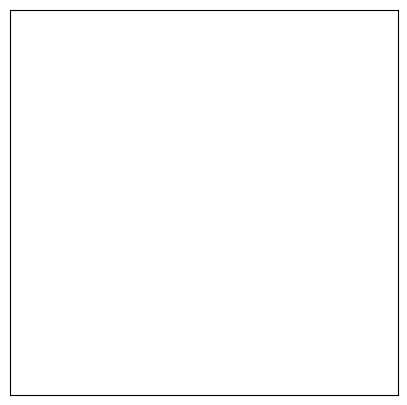

In [39]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap="Blues")

def animate(i):
    patch.set_data(data.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=number_of_steps, interval=10)

anim